### Run

In [10]:
from gensim.models import KeyedVectors
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from yellowbrick.cluster import KElbowVisualizer
from scipy.spatial.distance import cdist
import sumy
from flair.embeddings import FlairEmbeddings, TransformerWordEmbeddings , TransformerDocumentEmbeddings, SentenceTransformerDocumentEmbeddings
from flair.data import Sentence
import spacy
import pickle
import plotly.express as px
import plotly.graph_objects as go

### Word2Vec Embedding Initialisation

# get word2vec pretrained model 
model_w2v = KeyedVectors.load_word2vec_format('/Users/William/Desktop/Thesis_code/GoogleNews-vectors-negative300.bin', binary=True)

### Glove Embedding  Initialisation

model_glove =pd.read_pickle('/Users/William/Desktop/Thesis_code/glove_dict.pickle')


### BERT Sentence Embedding  Initialisation

bert_emb = SentenceTransformerDocumentEmbeddings('roberta-base')

# read in the data 
Hillary = pd.read_pickle('StanceDataset/Hillary.pkl')
Hillary_favor = pd.read_pickle('StanceDataset/Hillary_favor.pkl')
Hillary_against = pd.read_pickle('StanceDataset/Hillary_against.pkl')
Hillary_neither = pd.read_pickle('StanceDataset/Hillary_neither.pkl')
Abortion = pd.read_pickle('StanceDataset/Abortion.pkl')
Abortion_favor = pd.read_pickle('StanceDataset/Abortion_favor.pkl')
Abortion_against = pd.read_pickle('StanceDataset/Abortion_against.pkl')
Abortion_neither = pd.read_pickle('StanceDataset/Abortion_neither.pkl')
Atheism = pd.read_pickle('StanceDataset/Atheism.pkl')
Atheism_favor = pd.read_pickle('StanceDataset/Atheism_favor.pkl')
Atheism_against = pd.read_pickle('StanceDataset/Atheism_against.pkl')
Atheism_neither = pd.read_pickle('StanceDataset/Atheism_neither.pkl')
Climatechange = pd.read_pickle('StanceDataset/Climatechange.pkl')
Climatechange_favor = pd.read_pickle('StanceDataset/Climatechange_favor.pkl')
Climatechange_against = pd.read_pickle('StanceDataset/Climatechange_against.pkl')
Climatechange_neither = pd.read_pickle('StanceDataset/Climatechange_neither.pkl')
Feministmovement = pd.read_pickle('StanceDataset/Feministmovement.pkl')
Feministmovement_favor = pd.read_pickle('StanceDataset/Feministmovement_favor.pkl')
Feministmovement_against = pd.read_pickle('StanceDataset/Feministmovement_against.pkl')
Feministmovement_neither = pd.read_pickle('StanceDataset/Feministmovement_neither.pkl')


gsHillary_favor = pd.read_pickle('gsHillary_favor.pkl')
gsHillary_against = pd.read_pickle('gsHillary_against.pkl')
gsClimatechange_favor = pd.read_pickle('gsClimatechange_favor.pkl')
gsAbortion_favor = pd.read_pickle('gsAbortion_favor.pkl')
gsAbortion_against = pd.read_pickle('gsAbortion_against.pkl')
gsAtheism_favor = pd.read_pickle('gsAtheism_favor.pkl')
gsAtheism_against = pd.read_pickle('gsAtheism_against.pkl')
gsFeministmovement_favor = pd.read_pickle('gsFeministmovement_favor.pkl')
gsFeministmovement_against = pd.read_pickle('gsFeministmovement_against.pkl')



model_hil_favor = pd.read_pickle('StanceDataset/model_favor_hil.pkl')
model_hil_against =pd.read_pickle('StanceDataset/model_against_hil.pkl')
model_cc_favor =  pd.read_pickle('StanceDataset/model_favor_cc.pkl')
model_cc_against = pd.read_pickle('StanceDataset/model_against_cc.pkl') 
model_ab_favor =  pd.read_pickle('StanceDataset/model_favor_ab.pkl')
model_ab_against =pd.read_pickle('StanceDataset/model_against_ab.pkl')
model_ath_favor =pd.read_pickle('StanceDataset/model_favor_ath.pkl')
model_ath_against =pd.read_pickle('StanceDataset/model_against_ath.pkl')
model_fm_favor =pd.read_pickle('StanceDataset/model_favor_fm.pkl')
model_fm_against =pd.read_pickle('StanceDataset/model_against_fm.pkl')


H_fv = Hillary_favor.loc[Hillary_favor['Opinion Towards']== 'Argumentative']
H_ag = Hillary_against.loc[Hillary_against['Opinion Towards'] == 'Argumentative']
Ab_fv = Abortion_favor.loc[Abortion_favor['Opinion Towards'] == 'Argumentative']
Ab_ag = Abortion_against.loc[Abortion_against['Opinion Towards'] == 'Argumentative']
Ath_fv = Atheism_favor.loc[Atheism_favor['Opinion Towards'] == 'Argumentative']
Ath_ag = Atheism_against.loc[Atheism_against['Opinion Towards'] == 'Argumentative']
Fm_fv = Feministmovement_favor.loc[Feministmovement_favor['Opinion Towards'] == 'Argumentative']
Fm_ag = Feministmovement_against.loc[Feministmovement_against['Opinion Towards'] == 'Argumentative']
Cl_fv = Climatechange_favor.loc[Climatechange_favor['Opinion Towards'] == 'Argumentative']
Cl_ag = Climatechange_against.loc[Climatechange_against['Opinion Towards'] == 'Argumentative']

### Word2vec combined with tfidf feature scaling 

# function to get tfidf * word emb vector 
def tfidf_scaled_wv(data,model,dim):
    text = []
    for i in data['tokenize']:
        string = ' '.join(i)
        text.append(string)
    tfidf = TfidfVectorizer(stop_words =None)
    tf_idf_tr = tfidf.fit_transform(text)
    feature_names = tfidf.get_feature_names()
    sentences = data['tokenize'].values
    data_dtm = pd.DataFrame(tf_idf_tr.toarray(), columns = feature_names)
    tfidf_sent_vectors = [] 
    row = 0
    for sentence in sentences:
        sent_vec = np.zeros(dim)
        weight_sum = 0
        for word in sentence:
            try:
                vec = model[word]
                tfidf = data_dtm.iloc[row][word]
                sent_vec += (vec * tfidf)
                weight_sum += tfidf
            except:
                pass
            # check if weight_sum is zero meaning all words in that tweet gave no context 
        if weight_sum != 0:     
            sent_vec  /= weight_sum     
        tfidf_sent_vectors.append(sent_vec)
        row+=1
    return tfidf_sent_vectors
  

word_emb = tfidf_scaled_wv(Hillary_favor,model_w2v,300)
word_emb = np.array(word_emb)

### Sentence Embedding Using BERT


def get_embeddings(text):
    sentence = Sentence(text)
    bert_emb.embed(sentence)
    return sentence.embedding




def sentence_vec(data):
    # the returned embedding is a tensor so we used the pytorch method to detach into a numpy array
    detach = lambda x : x.detach().numpy()
    emb  = lambda x : get_embeddings(x)
    data['sen_emb'] = data.Processed_Tweet.apply(emb)
    data['sen_emb'] = data.sen_emb.apply(detach)
#     data['sen_emb'] = data.sen_emb.apply(lambda x: np.array(x))

### Visualize KMedoids to decide on optimal cluster 

def silhouette_method(word_emb):
    model = KMedoids(metric='cosine')
    # k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,15),metric='silhouette', timings= True)
    visualizer.fit(word_emb)        # Fit the data to the visualizer
#     visualizer.show()        # Finalize and render the figure
    k = visualizer.elbow_value_
    return k

k =silhouette_method(word_emb)

def calinski_method(word_emb):
    model = KMedoids(metric='cosine')
# k is range of number of clusters.
    visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
    visualizer.fit(word_emb)        # Fit the data to the visualizer
#     visualizer.show()        # Finalize and render the figure
    k = visualizer.elbow_value_
    return k

k = calinski_method(word_emb)

## Clustering using kmedoids  to generate summaries

### Word Vector Clustering ( Word2Vec , GloVe , Fasttext)

def clustering_w2v(corpus,model,dim):
    data = corpus.copy()
    #get the word vector 
    word_emb = np.array(tfidf_scaled_wv(data,model,dim))
    #find the average optimal k clusters using silhouette method and calinski method
    k_1 = silhouette_method(word_emb)
    k_2 = calinski_method(word_emb)
    opt_k = int((k_1 + k_2) / 2)
    kmedoids = KMedoids(metric= 'cosine', n_clusters = opt_k)
    kmedoids.fit(word_emb)
    assigned_clusters = kmedoids.labels_
    dist_clusters = kmedoids.transform(word_emb)
    sq_dis = dist_clusters ** 2
    cluster_centers = kmedoids.cluster_centers_
    # distance matrix  using cosine similarity
    dm_cos = cdist(word_emb, cluster_centers, metric='cosine')
    dm_eucl = cdist(word_emb, cluster_centers, metric='euclidean')
    dis_eucl = np.array([dm_eucl[i][x] for i,x in enumerate(assigned_clusters)])
    dis_cos = np.array([dm_cos[i][x] for i,x in enumerate(assigned_clusters)])
    data['cluster'] = assigned_clusters
    data['centroid'] = data.cluster.apply(lambda x: cluster_centers[x])
    data['cosine_dis_from_centroid'] = dis_cos
    data['euclidean_dis_from_centroid'] =dis_eucl
    return data,opt_k
    
    
    
    
    
        

### Sentence Vector (BERT) Clustering  

def clustering_sen2v(corpus):
    data = corpus.copy()
    #get the word vector
    sen_emb = data['sen_emb'].tolist()
    sen_emb = np.array(sen_emb)
    #find the average optimal k clusters using silhouette method and calinski method
    k_1 = silhouette_method(sen_emb)
    k_2 = calinski_method(sen_emb)
    opt_k = int((k_1 + k_2) / 2)
    kmedoids = KMedoids(metric= 'cosine', n_clusters = opt_k)
    kmedoids.fit(sen_emb)
    assigned_clusters = kmedoids.labels_
    dist_clusters = kmedoids.transform(sen_emb)
    sq_dis = dist_clusters ** 2
    cluster_centers = kmedoids.cluster_centers_
    # distance matrix  using cosine similarity
    dm_cos = cdist(sen_emb, cluster_centers, metric='cosine')
    dm_eucl = cdist(sen_emb, cluster_centers, metric='euclidean')
    dis_eucl = np.array([dm_eucl[i][x] for i,x in enumerate(assigned_clusters)])
    dis_cos = np.array([dm_cos[i][x] for i,x in enumerate(assigned_clusters)])
    data['cluster'] = assigned_clusters
    data['centroid'] = data.cluster.apply(lambda x: cluster_centers[x])
    data['cosine_dis_from_centroid'] = dis_cos
    data['euclidean_dis_from_centroid'] =dis_eucl
    return data,opt_k
    
    
    

# analyis of cluster to generate effective summaries by measure of distances 
def cluster_dis_summary(data,k,num_tweets=None):
    # list of tweets around centroid and tweet closest to centroid for each cluster
    count = 0
    index = 0
#   cluster number
    cn = 1
    tweets_cos = []
    tweets_eucl = []
    # k is the number of cluster
    while count != num_tweets:
        df = data.loc[data['cluster'] == cn]
        # mean distance to cluster centroid         
        a = df['cosine_dis_from_centroid'].mean()
        b = df['euclidean_dis_from_centroid'].mean()
        # pool of tweets based on cosine  and euclidean distance
        summ_cos = df.loc[df['cosine_dis_from_centroid'] <= a]
        summ_eucl = df.loc[df['euclidean_dis_from_centroid'] <= b]
        summ_cos = summ_cos.sort_values(['cosine_dis_from_centroid'])
        summ_eucl = summ_eucl.sort_values(['euclidean_dis_from_centroid'])
        #tweet closest to centroid based on cosine and euclidean dsitance
        closest_cos = summ_cos.iloc[index]
        closest_eucl = summ_eucl.iloc[index]
        # add them to our lists 
        tweets_cos.append(closest_cos['Tweet'])
        tweets_eucl.append(closest_eucl['Tweet'])
       #update cluster number      
        cn = (cn + 1) % k 
      #update count 
        count +=1
#     update index only if we checked all clusters
        if  count % k == 0:
            index +=1
#             print('count:',count)
#             print('index :',index)
        
    return tweets_cos,tweets_eucl
    
        
                
        
    

### Baseline Summarization using implementation of SumBasic  Algorithm

from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
import nltk

lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
lemmatize = True
rm_stopwords = True


# my own implementation of sumbasic
def clean_sentence(tokens):
    if lemmatize: tokens = [lemmatizer.lemmatize(t) for t in tokens]
    if rm_stopwords: tokens = [t for t in tokens if t not in stopwords]
    return tokens

def get_probabilities(data):
    word_ps = {}    
    token_count = 0
    for sentence in data['Processed_Tweet_sw']:
        sentence = nltk.word_tokenize(sentence)
        tokens = clean_sentence(sentence)
        token_count += len(tokens)
        for token in tokens:
            if token not in word_ps:
                word_ps[token] = 1
            else:
                word_ps[token] += 1
    for word_p in word_ps:
        word_ps[word_p] = word_ps[word_p]/float(token_count)   
    return word_ps

def score_sentence(sentence,word_ps):
    score = 0
    num_tokens = 0
    tokenize_sentence = nltk.word_tokenize(sentence)
    tokens = clean_sentence(tokenize_sentence)
    for token in tokens:
        if  token in word_ps:
            score += word_ps[token]
            num_tokens +=1 
    if tokens == []: return 0
    return float(score)/float(num_tokens)


def max_sentence(sentences,word_ps):
    max_sentence =  None
    max_score =  float('-inf')
    for sentence in sentences['Processed_Tweet_sw']:
        score = score_sentence(sentence,word_ps)
        if score > max_score or max_score ==  float('-inf'):
            max_sentence = sentence
            max_score = score
    update_ps(max_sentence,word_ps)
    return max_sentence

def update_ps(max_sentence, word_ps):
    sentence = nltk.word_tokenize(max_sentence)
    tokens = clean_sentence(sentence)
    for word in tokens:
        word_ps[word] = word_ps[word]**2

# baseline function to find summary of tweets
def orig_sumBasic(df,num_sentences):
    word_ps = get_probabilities(df)
    summary = []
    summ = []
    for i in range(num_sentences):
        summary.append(max_sentence(df, word_ps))
    for s in summary:
        for index, row in df.iterrows():
            if row['Processed_Tweet_sw'] == s:
                summ.append(row['Tweet'])
                break
    return summ

from gensim.summarization.summarizer import summarize

def textrank(df,gold_standard):
    results =[]
    values = df.Processed_Tweet_sw.apply(lambda x: x + '.')
    text = ' '.join(values.tolist())
    summary = summarize(text,len(gold_standard)/len(df),split=True)
    summary = [summ.replace(".", "") for summ in summary]
    for s in summary:
        for index, row in df.iterrows():
            if row['Processed_Tweet_sw'] == s:
                    results.append(row['Tweet'])
                    break
    return results

### ROUGE Metric Evaluation Model

from rouge import Rouge

rouge = Rouge()

# refs, datas
refs = [gsHillary_favor,gsHillary_against,gsClimatechange_favor,gsAbortion_favor,gsAbortion_against,gsAtheism_favor,gsAtheism_against,gsFeministmovement_favor,
       gsFeministmovement_against]

datas = [H_fv,H_ag,Cl_fv,Ab_fv,Ab_ag,Ath_fv,Ath_ag,
        Fm_fv,Fm_ag,]


for data in datas:
    sentence_vec(data)
# datas = [model_hil_favor,model_hil_against,model_cc_favor,model_ab_favor,model_ab_against,model_ath_favor,model_ath_against,model_fm_favor,model_fm_against]

names = ['Hillary_favor','Hillary_against','Climatechange_favor','Abortion_favor','Abortion_against','Atheism_favor','Atheism_against',
        'Feministmovement_favor','Feministmovement_against']

# sum_basic = orig_sumBasic(Fm_fv,len(gsFeministmovement_favor))

# sum_basic

# data, k = clustering_sen2v(Fm_fv)
# bert_summarycos, eul = cluster_dis_summary(data,k,len(gsFeministmovement_favor))

# bert_summarycos

# data , k = clustering_w2v(Fm_fv,model_glove,200)
# glove_summarycos, euc = cluster_dis_summary(data,k,len(gsFeministmovement_favor))

# glove_summarycos

# data , k = clustering_w2v(Fm_fv,model_w2v,300)
# w2v_summarycos, euc = cluster_dis_summary(data,k,len(gsFeministmovement_favor))

# w2v_summarycos

# tr_1 = textrank(Fm_fv,gsFeministmovement_favor)

# tr_1

## Evaluation of summaries 

models = ['BERT','word2vec','glove']

# evaluation for distance summary
def evaluation(models):
    list_of_scores = { 'Hillary_favor' :  {"SB" : None, "textrank" : None ,"model_w2v": None , "model_glove" : None, "BERT": None} ,
                  'Hillary_against' :  { "SB" : None, "textrank" : None,"model_w2v" : None ,"model_glove" : None, "BERT": None}  ,
                  'Climatechange_favor' :  {"SB": None,"textrank" : None, "model_w2v": None ,"model_glove" : None, "BERT": None} ,
                  'Abortion_favor' : { "SB": None, "textrank" : None, "model_w2v": None ,"model_glove" : None, "BERT": None} ,
                  'Abortion_against' :  {"SB": None, "textrank" : None, "model_w2v": None,"model_glove" : None, "BERT": None} ,
                  'Atheism_favor' : { "SB": None,  "textrank" : None,"model_w2v": None,"model_glove" : None, "BERT": None } ,
                  'Atheism_against':  { "SB" : None,"textrank" : None, "model_w2v": None ,"model_glove" : None, "BERT": None} ,
                  'Feministmovement_favor' : {"SB": None,"textrank" : None,  "model_w2v": None,"model_glove" : None, "BERT": None } ,
                  'Feministmovement_against' :  {"SB": None,"textrank" : None, "model_w2v" : None,"model_glove" : None, "BERT": None }  
                 } 
        
    for i in range(len(datas)):
        if len(datas[i]) >= 65:
            for model in models:
                if model == 'word2vec': data, k= clustering_w2v(datas[i],model_w2v,300)
                if model == 'BERT': data,k = clustering_sen2v(datas[i])
                if model == 'glove': data,k = clustering_w2v(datas[i],model_glove,200)
                cos_sum, eucl_sum = cluster_dis_summary(data,k,num_tweets=len(refs[i]))
                sum_basic = orig_sumBasic(datas[i],len(refs[i]))
                TR = textrank(datas[i],refs[i])
                #sumbasic scores
                scores_SB = rouge.get_scores(" ".join(sum_basic)," ".join(refs[i]['Tweet']))
                scores_TR = rouge.get_scores(" ".join(TR)," ".join(refs[i]['Tweet']))
                #model scores
                scores_model = rouge.get_scores(" ".join(cos_sum), " ".join(refs[i]['Tweet']))
                #add to our dictionary of scores
                list_of_scores[names[i]]["SB"] = scores_SB
                list_of_scores[names[i]]["textrank"] = scores_TR
                if model == 'word2vec':  
                    list_of_scores[names[i]]["model_w2v"] = scores_model 
                elif model == 'glove':
                    list_of_scores[names[i]]["model_glove"] = scores_model
                elif model == 'BERT':
                    list_of_scores[names[i]]["BERT"] = scores_model
                print('------------------Generated results for :', names[i])
    return list_of_scores
       
        

# evaluation for feature ranking summary
def evaluation_2(model):
    list_of_scores = { 'Hillary_favor' :  {"SB" : None, "model_w2v": None } ,
                  'Hillary_against' :  { "SB" : None, "model_w2v" : None }  ,
                  'Climatechange_favor' :  {"SB": None, "model_w2v": None } ,
                  'Abortion_favor' : { "SB": None, "model_w2v": None } ,
                  'Abortion_against' :  {"SB": None, "model_w2v": None } ,
                  'Atheism_favor' : { "SB": None, "model_w2v": None } ,
                  'Atheism_against':  { "SB" : None, "model_w2v": None } ,
                  'Feministmovement_favor' : {"SB": None, "model_w2v": None } ,
                  'Feministmovement_against' :  {"SB": None, "model_w2v" : None }  
                 } 
        
    for i in range(len(datas)):
        if model == 'word2vec': data, k= clustering_w2v(datas[i],model_w2v)
        if model == 'BERT': data,k = clustering_sen2v(datas[i])
        summary = cluster_feature_summary(data,k,num_tweets=len(refs[i]))
        sum_basic = orig_sumBasic(datas[i],len(refs[i]))
        #sumbasic scores
        scores_SB = rouge.get_scores(" ".join(sum_basic)," ".join(refs[i]['Tweet']))
        #model scores
        scores_model = rouge.get_scores(" ".join(summary), " ".join(refs[i]['Tweet']))
        # add to our dictionary of scores
        list_of_scores[names[i]]["SB"] = scores_SB
        list_of_scores[names[i]]["model_w2v"] = scores_model
        print('------ Generated results for :', names[i])
#         print(list_of_scores)
    return list_of_scores
    
    
    

def SB_avg_all(scores):
    f1_1 = 0
    f1_2 = 0
    f1_l = 0
    for i in names:
        f1_1+= scores[i]['SB'][0]['rouge-1']['f']
        f1_2+= scores[i]['SB'][0]['rouge-2']['f']
        f1_l+= scores[i]['SB'][0]['rouge-l']['f']
    return float(f1_1)/9 , float(f1_2) / 9 , float(f1_l) / 9


def TR_avg_all(scores):
    f1_1 = 0
    f1_2 = 0
    f1_l = 0
    for i in names:
        f1_1+= scores[i]['textrank'][0]['rouge-1']['f']
        f1_2+= scores[i]['textrank'][0]['rouge-2']['f']
        f1_l+= scores[i]['textrank'][0]['rouge-l']['f']
    return float(f1_1)/9 , float(f1_2) / 9 , float(f1_l) / 9

def w2v_avg_all(scores):
    f1_1 = 0
    f1_2 = 0
    f1_l = 0
    for i in names:
        f1_1+= scores[i]['model_w2v'][0]['rouge-1']['f']
        f1_2+= scores[i]['model_w2v'][0]['rouge-2']['f']
        f1_l+= scores[i]['model_w2v'][0]['rouge-l']['f']
    return float(f1_1)/9 , float(f1_2) / 9 , float(f1_l) / 9



def glove_avg_all(scores):
    f1_1 = 0
    f1_2 = 0
    f1_l = 0
    for i in names:
        f1_1+= scores[i]['model_glove'][0]['rouge-1']['f']
        f1_2+= scores[i]['model_glove'][0]['rouge-2']['f']
        f1_l+= scores[i]['model_glove'][0]['rouge-l']['f']
    return float(f1_1)/9 , float(f1_2) / 9 , float(f1_l) / 9


def BERT_avg_all(scores):
    f1_1 = 0
    f1_2 = 0
    f1_l = 0
    for i in names:
        f1_1+= scores[i]['BERT'][0]['rouge-1']['f']
        f1_2+= scores[i]['BERT'][0]['rouge-2']['f']
        f1_l+= scores[i]['BERT'][0]['rouge-l']['f']
    return float(f1_1)/9 , float(f1_2) / 9 , float(f1_l) / 9


def scoring(scores):
    SB = SB_avg_all(scores)
    TR = TR_avg_all(scores)
    glove = glove_avg_all(scores)
    w2v = w2v_avg_all(scores)
    BERT = BERT_avg_all(scores)
    return SB,TR,glove,w2v,BERT


scores = evaluation(models)
SB,TR,glove,w2v,BERT = scoring(scores)

print(SB)
print(TR)
print(glove)
print(BERT)
print(w2v)

<AxesSubplot:>

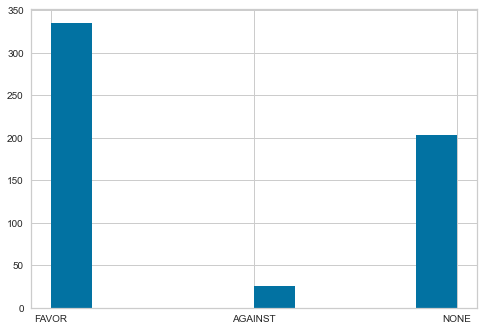

In [18]:
Climatechange['Stance'].hist()